INSTALLING NECESSARY PACKAGES FOR IMAGE PROCESSING

In [1]:
pip install opencv-python scikit-image numpy scipy

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas numpy openpyxl

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: '/usr/local/lib/python3.11/aims/lib/python3.11/site-packages/et_xmlfile'
Check the permissions.

Note: you may need to restart the kernel to use updated packages.


IMPORTING LIBRARY FOR IMAGE PROCESSING

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.measure import label, regionprops
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

IMAGE DIRECTORY AND LISTING THE FEATURES

In [7]:
image_dir = Path("/home/amukelani/Documents/notebooks/Hydrogen Storage Project/SEM Images/IMAGES/")

LOADING IMAGES

In [9]:
def load_image(image_path):
    """Load an SEM image."""
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not load image at {image_dir}")
        return None
    return img

PREPROCESSING IMAGES

In [13]:
def preprocess_image(img):
    """Converting images to grayscale and apply thresholding for binary image."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Applying Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Using Otsu's thresholding method identify the binary fill holes between the particles and background for better results with SEM images
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Invert if particles are dark on light background
    if np.mean(thresh) > 127:  # If more white than black
        thresh = cv2.bitwise_not(thresh)
        
    # Applying morphological operations to clean up the image
    kernel = np.ones((3, 3), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    
    return thresh, gray

USING WATERSHED ALGORITHM TO SEGMENTING PARTICLES

In [15]:
def segment_particles(binary_img):
    """Using watershed algorithm to segment particles."""
    # Compute the distance transform
    distance = distance_transform_edt(binary_img)
    
    # Find peaks in the distance transform
    coords = peak_local_max(distance, min_distance=5, labels=binary_img)
    
    if len(coords) == 0:
        # Fallback to connected components if watershed fails
        labels = label(binary_img)
        return labels
    
    # Create marker image
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    
    # Apply watershed algorithm
    labels = watershed(-distance, markers, mask=binary_img, watershed_line=True)
    
    return labels

CALCULATING THE FRACTAL DIMENSION USING THE BOX COUNTING METHOD

In [16]:
def box_counting_fractal_dimension(binary_img, plot=False):
    """Calculating fractal dimension using box-counting method."""
    # Ensure the image is binary
    binary_img = binary_img > 0
    
    # Determine the maximum box size (power of 2)
    min_dim = min(binary_img.shape)
    max_size = 2 ** int(np.log2(min_dim))
    
    # Generate box sizes
    sizes = 2 ** np.arange(1, int(np.log2(max_size)) + 1)
    sizes = sizes[::-1]  # Start with largest boxes
    
    counts = []
    valid_sizes = []
    
    for size in sizes:
        if size < 2:
            continue
            
        # Count boxes that contain at least one white pixel
        box_count = 0
        for i in range(0, binary_img.shape[0], size):
            for j in range(0, binary_img.shape[1], size):
                box = binary_img[i:min(i+size, binary_img.shape[0]), 
                               j:min(j+size, binary_img.shape[1])]
                if np.any(box):
                    box_count += 1
                    
        counts.append(box_count)
        valid_sizes.append(size)
    
    if len(counts) < 2:
        return 0.0
    
    # Linear fit in log-log space
    coeffs = np.polyfit(np.log(valid_sizes), np.log(counts), 1)
    
    if plot:
        plt.figure(figsize=(8, 6))
        plt.loglog(valid_sizes, counts, 'bo-')
        plt.xlabel('Box Size (log)')
        plt.ylabel('Box Count (log)')
        plt.title(f'Fractal Dimension: {-coeffs[0]:.3f}')
        plt.grid(True, which="both", ls="--")
        plt.show()
    
    return -coeffs[0]


CALCULATING THE MORPHOLOGICAL FEATURES FROM LABELED PARTICLES

In [17]:
def calculate_particle_features(labels, binary_img, gray_img, pixel_to_micron=1.0):
    """Calculate morphological features from labeled particles."""
    props = regionprops(labels, intensity_image=gray_img)
    
    # Number of particles
    num_particles = len(props)
    
    # Diameters (equivalent diameter = sqrt(4*area/pi))
    diameters = [prop.equivalent_diameter * pixel_to_micron for prop in props]
    avg_diameter = np.mean(diameters) if diameters else 0
    std_diameter = np.std(diameters) if diameters else 0
    min_diameter = np.min(diameters) if diameters else 0
    max_diameter = np.max(diameters) if diameters else 0
    
    # Area fractions
    particle_area = np.sum(binary_img > 0)
    image_area = binary_img.size
    particle_area_fraction = particle_area / image_area if image_area > 0 else 0
    pore_area_fraction = 1 - particle_area_fraction
    
    # Shape descriptors
    aspect_ratios = []
    circularities = []
    solidities = []
    
    for prop in props:
        # Aspect ratio (major_axis_length / minor_axis_length)
        if prop.minor_axis_length > 0:
            aspect_ratio = prop.major_axis_length / prop.minor_axis_length
        else:
            aspect_ratio = 1
        aspect_ratios.append(aspect_ratio)
        
        # Circularity = 4 * pi * area / perimeter^2
        if prop.perimeter > 0:
            circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
        else:
            circularity = 0
        circularities.append(circularity)
        
        # Solidity = area / convex_area
        if prop.convex_area > 0:
            solidity = prop.area / prop.convex_area
        else:
            solidity = 1
        solidities.append(solidity)
    
    avg_aspect = np.mean(aspect_ratios) if aspect_ratios else 0
    std_aspect = np.std(aspect_ratios) if aspect_ratios else 0
    avg_circularity = np.mean(circularities) if circularities else 0
    std_circularity = np.std(circularities) if circularities else 0
    avg_solidity = np.mean(solidities) if solidities else 0
    std_solidity = np.std(solidities) if solidities else 0
    
    # Agglomeration degree (mean distance between centroids)
    centroids = [prop.centroid for prop in props]
    if len(centroids) > 1:
        dists = []
        for i, c1 in enumerate(centroids):
            for j, c2 in enumerate(centroids[i+1:], i+1):
                dist = np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2) * pixel_to_micron
                dists.append(dist)
        agglomeration_degree = np.mean(dists) if dists else 0
    else:
        agglomeration_degree = 0
    
    # Grain boundary density (edge length per area using Canny edges)
    edges = cv2.Canny(gray_img, 50, 150)
    boundary_length = np.sum(edges > 0)
    grain_boundary_density = boundary_length / image_area if image_area > 0 else 0
    
    # Fractal dimension (box counting method)
    fractal_dimension = box_counting_fractal_dimension(binary_img)
    
    return {
        'Image_ID': '',  # Will be set to filename
        'Image_Width': binary_img.shape[1],
        'Image_Height': binary_img.shape[0],
        'Number_of_Particles': num_particles,
        'Avg_Diameter_µm': avg_diameter,
        'Std_Diameter_µm': std_diameter,
        'Min_Diameter_µm': min_diameter,
        'Max_Diameter_µm': max_diameter,
        'Pore_Area_Fraction': pore_area_fraction,
        'Particle_Area_Fraction': particle_area_fraction,
        'Aspect_Ratio_Avg': avg_aspect,
        'Aspect_Ratio_Std': std_aspect,
        'Circularity_Avg': avg_circularity,
        'Circularity_Std': std_circularity,
        'Solidity_Avg': avg_solidity,
        'Solidity_Std': std_solidity,
        'Agglomeration_Degree': agglomeration_degree,
        'Grain_Boundary_Density': grain_boundary_density,
        'Fractal_Dimension': fractal_dimension
    }


PREPROCESSING ALL THE IMAGES IN THE WORKING DIRECTORY AND CREATE A FEATURE MATRIX

In [26]:
def calculate_particle_features(labels, binary_img, gray_img, pixel_to_micron=1.0):
    """Calculate morphological features from labeled particles."""
    props = regionprops(labels, intensity_image=gray_img)
    
    # Number of particles
    num_particles = len(props)
    
    # Diameters (equivalent diameter = sqrt(4*area/pi))
    diameters = [prop.equivalent_diameter * pixel_to_micron for prop in props]
    avg_diameter = np.mean(diameters) if diameters else 0
    std_diameter = np.std(diameters) if diameters else 0
    min_diameter = np.min(diameters) if diameters else 0
    max_diameter = np.max(diameters) if diameters else 0
    
    # Area fractions
    particle_area = np.sum(binary_img > 0)
    image_area = binary_img.size
    particle_area_fraction = particle_area / image_area if image_area > 0 else 0
    pore_area_fraction = 1 - particle_area_fraction
    
    # Shape descriptors
    aspect_ratios = []
    circularities = []
    solidities = []
    
    for prop in props:
        # Aspect ratio (major_axis_length / minor_axis_length)
        if prop.minor_axis_length > 0:
            aspect_ratio = prop.major_axis_length / prop.minor_axis_length
        else:
            aspect_ratio = 1
        aspect_ratios.append(aspect_ratio)
        
        # Circularity = 4 * pi * area / perimeter^2
        if prop.perimeter > 0:
            circularity = (4 * np.pi * prop.area) / (prop.perimeter ** 2)
        else:
            circularity = 0
        circularities.append(circularity)
        
        # Solidity = area / convex_area
        if prop.convex_area > 0:
            solidity = prop.area / prop.convex_area
        else:
            solidity = 1
        solidities.append(solidity)
    
    avg_aspect = np.mean(aspect_ratios) if aspect_ratios else 0
    std_aspect = np.std(aspect_ratios) if aspect_ratios else 0
    avg_circularity = np.mean(circularities) if circularities else 0
    std_circularity = np.std(circularities) if circularities else 0
    avg_solidity = np.mean(solidities) if solidities else 0
    std_solidity = np.std(solidities) if solidities else 0
    
    # Agglomeration degree (mean distance between centroids)
    centroids = [prop.centroid for prop in props]
    if len(centroids) > 1:
        dists = []
        for i, c1 in enumerate(centroids):
            for j, c2 in enumerate(centroids[i+1:], i+1):
                dist = np.sqrt((c1[0]-c2[0])**2 + (c1[1]-c2[1])**2) * pixel_to_micron
                dists.append(dist)
        agglomeration_degree = np.mean(dists) if dists else 0
    else:
        agglomeration_degree = 0
    
    # Grain boundary density (edge length per area using Canny edges)
    edges = cv2.Canny(gray_img, 50, 150)
    boundary_length = np.sum(edges > 0)
    grain_boundary_density = boundary_length / image_area if image_area > 0 else 0
    
    # Fractal dimension (box counting method)
    fractal_dimension = box_counting_fractal_dimension(binary_img)
    
    return {
        'Image_ID': '',  # Will be set to filename
        'Image_Width': binary_img.shape[1],
        'Image_Height': binary_img.shape[0],
        'Number_of_Particles': num_particles,
        'Avg_Diameter_µm': avg_diameter,
        'Std_Diameter_µm': std_diameter,
        'Min_Diameter_µm': min_diameter,
        'Max_Diameter_µm': max_diameter,
        'Pore_Area_Fraction': pore_area_fraction,
        'Particle_Area_Fraction': particle_area_fraction,
        'Aspect_Ratio_Avg': avg_aspect,
        'Aspect_Ratio_Std': std_aspect,
        'Circularity_Avg': avg_circularity,
        'Circularity_Std': std_circularity,
        'Solidity_Avg': avg_solidity,
        'Solidity_Std': std_solidity,
        'Agglomeration_Degree': agglomeration_degree,
        'Grain_Boundary_Density': grain_boundary_density,
        'Fractal_Dimension': fractal_dimension
    }

def process_sem_images(image_dir, pixel_to_micron=1.0, output_csv='sem_morphological_features_output.csv'):
    """Process all SEM images in the directory and create feature matrix."""
    # Supported image extensions
    valid_extensions = ('.jpg', '.jpeg', '.png', '.tif', '.tiff', '.bmp')
    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(valid_extensions)]
    image_paths = [os.path.join(image_dir, f) for f in image_files]
    
    if not image_paths:
        raise ValueError(f"No valid images found in {image_dir}")
    
    features_list = []
    processed_count = 0
    
    for i, path in enumerate(image_paths):
        print(f"Processing image {i+1}/{len(image_paths)}: {os.path.basename(path)}")
        
        img = load_image(path)
        if img is None:
            continue
            
        try:
            binary_img, gray_img = preprocess_image(img)
            labels = segment_particles(binary_img)
            features = calculate_particle_features(labels, binary_img, gray_img, pixel_to_micron)
            features['Image_ID'] = os.path.basename(path)
            features_list.append(features)
            processed_count += 1
        except Exception as e:
            print(f"Error processing {path}: {str(e)}")
            continue
    
    print(f"Successfully processed {processed_count} images")
    
    if not features_list:
        print("No features extracted from any images")
        return None
    
    # Create DataFrame
    feature_matrix = pd.DataFrame(features_list)
    
    # Save to CSV
    feature_matrix.to_csv(output_csv, index=False)
    print(f"Feature matrix saved to {output_csv}")
    
    # Display summary statistics
    print("\nSummary Statistics:")
    print("=" * 50)
    numeric_cols = feature_matrix.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols.remove('Image_Width')  # These are not features
    numeric_cols.remove('Image_Height')  # These are not features
    
    summary = feature_matrix[numeric_cols].describe()
    print(summary.round(4))
    
    return feature_matrix


ADJUSTMENTS MADE BASED ON SEM SCALE AND PRINTING THE MATRIX OUTPUT

In [30]:
if __name__ == "__main__":
    pixel_to_micron = 1.0  # Adjust this based on your SEM scale (microns per pixel)
    output_csv = 'sem_morphological_features_output.csv'
    
    try:
        feature_matrix = process_sem_images(image_dir, pixel_to_micron, output_csv)
        if feature_matrix is not None:
            print(f"\nFirst few rows of the feature matrix:")
            print(feature_matrix.head())
    except Exception as e:
        print(f"Error: {str(e)}")

Processing image 1/303: SEM_074.png
Processing image 2/303: SEM_008.png
Processing image 3/303: SEM_296.png
Processing image 4/303: SEM_150.png
Processing image 5/303: SEM_181.png
Processing image 6/303: SEM_247.png
Processing image 7/303: SEM_291.png
Processing image 8/303: SEM_157.png
Processing image 9/303: SEM_186.png
Processing image 10/303: SEM_240.png
Processing image 11/303: SEM_073.png
Processing image 12/303: SEM_159.png
Processing image 13/303: SEM_188.png
Processing image 14/303: SEM_125.png
Processing image 15/303: SEM_001 .png
Processing image 16/303: SEM_232.png
Processing image 17/303: SEM_104.jpg
Processing image 18/303: SEM_122.png
Processing image 19/303: SEM_235.png
Processing image 20/303: SEM_006.png
Processing image 21/303: SEM_298.png
Processing image 22/303: SEM_249.png
Processing image 23/303: SEM_200.png
Processing image 24/303: SEM_117.png
Processing image 25/303: SEM_034.png
Processing image 26/303: SEM_012.jpg
Processing image 27/303: SEM_048.png
Processin

CODE USED TO CREATE THE METHODOLOGY FLOWCHART OF MY PROJECT

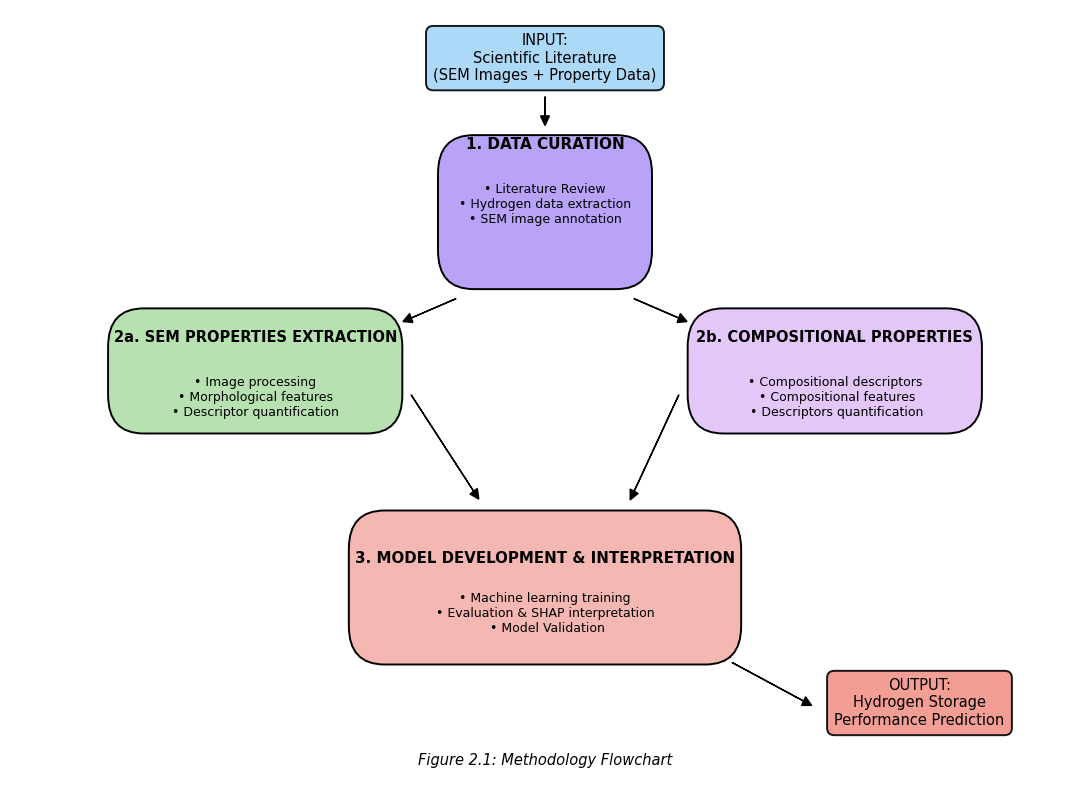

Flowchart saved as 'methodology_flowchart_structured.png' and 'methodology_flowchart_structured.pdf'


In [10]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(11, 8))
ax.set_xlim(0, 12)
ax.set_ylim(0, 8)
ax.axis('off')  # Hide axes

# Box style
box_props = {'boxstyle': 'round,pad=0.4', 'linewidth': 1.4, 'edgecolor': 'black'}

# Colors
colors = {
    'input': '#A3D5F7',
    'curation': '#B8A3F7',
    'sem': '#B7E1B0',
    'thermo': '#E3C7F9',
    'model': '#F5B7B1',
    'output': '#F1948A'
}

# ======================
# INPUT (Top)
# ======================
ax.text(6, 7.5, 'INPUT:\nScientific Literature\n(SEM Images + Property Data)', 
        ha='center', va='center', fontsize=10.5,
        bbox=dict(boxstyle='round,pad=0.5', facecolor=colors['input'], alpha=0.9, linewidth=1.4))

# Arrow to Data Curation
ax.arrow(6, 7.1, 0, -0.2, head_width=0.1, head_length=0.1, fc='k', ec='k', lw=1)

# ======================
# DATA CURATION (Middle Top)
# ======================
ax.add_patch(patches.FancyBboxPatch((5.2, 5.5), 1.6, 0.8, facecolor=colors['curation'], **box_props))  # narrower & taller
ax.text(6, 6.6, '1. DATA CURATION', ha='center', va='center', fontsize=11, fontweight='bold')
ax.text(6, 6.2,
        '• Literature Review\n• Hydrogen data extraction\n• SEM image annotation',
        ha='center', va='top', fontsize=9)

# Arrows to SEM & Compo
# Left arrow to SEM
ax.arrow(5.0, 5.0, -0.5, -0.2, head_width=0.1, head_length=0.1, fc='k', ec='k', lw=1)
# Right arrow to Compo
ax.arrow(7.0, 5.0, 0.5, -0.2, head_width=0.1, head_length=0.1, fc='k', ec='k', lw=1)

# ======================
# SEM PROPERTIES EXTRACTION (Left Middle)
# ======================
ax.add_patch(patches.FancyBboxPatch((1.5, 4.0), 2.5, 0.5, facecolor=colors['sem'], **box_props))  # narrower & taller
ax.text(2.75, 4.6, '2a. SEM PROPERTIES EXTRACTION', ha='center', va='center', fontsize=10.5, fontweight='bold')
ax.text(2.75, 4.2,
        '• Image processing\n• Morphological features\n• Descriptor quantification',
        ha='center', va='top', fontsize=9)

# COMPOSITIONAL PROPERTIES (Right Middle)
ax.add_patch(patches.FancyBboxPatch((8.0, 4.0), 2.5, 0.5, facecolor=colors['thermo'], **box_props))  # narrower & taller
ax.text(9.25, 4.6, '2b. COMPOSITIONAL PROPERTIES', ha='center', va='center', fontsize=10.5, fontweight='bold')
ax.text(9.25, 4.2,
        '• Compositional descriptors\n • Compositional features\n • Descriptors quantification\n',
        ha='center', va='top', fontsize=9)

# ======================
# MODEL DEVELOPMENT & INTERPRETATION (Bottom, aligned with OUTPUT)
# ======================
ax.add_patch(patches.FancyBboxPatch((6.0 - 1.8, 1.6), 3.6, 0.8, facecolor=colors['model'], **box_props))  # taller
ax.text(6, 2.3, '3. MODEL DEVELOPMENT & INTERPRETATION', ha='center', va='center', fontsize=10.8, fontweight='bold')
ax.text(6, 1.95, 
        '• Machine learning training\n• Evaluation & SHAP interpretation\n • Model Validation\n',
        ha='center', va='top', fontsize=9)

# ======================
# Arrows from SEM/COMPO to MODEL (Y-shape)
# ======================
ax.arrow(4.5, 4.0, 0.7, -1.0, head_width=0.1, head_length=0.1, fc='k', ec='k', lw=1)  # SEM → Model
ax.arrow(7.5, 4.0, -0.5, -1.0, head_width=0.1, head_length=0.1, fc='k', ec='k', lw=1)  # COMPO → Model

# Arrow from MODEL to OUTPUT (Bottom Right Corner)
ax.arrow(8.1, 1.22, 0.8, -0.40, head_width=0.1, head_length=0.1, fc='k', ec='k', lw=1)

# ======================
# OUTPUT (Bottom Right)
# ======================
ax.text(10.2, 0.8, 'OUTPUT:\nHydrogen Storage\nPerformance Prediction', 
        ha='center', va='center', fontsize=10.5,
        bbox=dict(boxstyle='round,pad=0.5', facecolor=colors['output'], alpha=0.9, linewidth=1.4))

# ======================
# Figure title
# ======================
plt.text(6, 0.2, 'Figure 2.1: Methodology Flowchart', ha='center', va='center', fontsize=10.5, style='italic')

plt.tight_layout()
plt.savefig('methodology_flowchart_structured.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig('methodology_flowchart_structured.pdf', bbox_inches='tight', facecolor='white')
plt.show()

print("Flowchart saved as 'methodology_flowchart_structured.png' and 'methodology_flowchart_structured.pdf'")